In [1]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Ignore warnings:
warnings.filterwarnings('ignore')

# Reading the dataset
bostonDF = pd.read_csv("../data/raw/boston.csv")
pd.set_option('display.max_columns', None)
bostonDF.head()

,OBS.,TOWN,TOWN#,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,2,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,3,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,4,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,5,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


| Variable | Descripción |
| :--- | :--- |
| **CRIM** | Tasa de criminalidad per cápita por ciudad |
| **ZN** | Proporción de suelo residencial dividido en lotes de más de 25,000 pies cuadrados |
| **INDUS** | Proporción de acres de negocios no minoristas por ciudad |
| **CHAS** | Variable ficticia del río Charles (= 1 si el tramo limita con el río; 0 en caso contrario) |
| **NOX** | Concentración de óxidos nítricos (partes por 10 millones) |
| **RM** | Número promedio de habitaciones por vivienda |
| **AGE** | Proporción de unidades ocupadas por sus propietarios construidas antes de 1940 |
| **DIS** | Distancias ponderadas a cinco centros de empleo de Boston |
| **RAD** | Índice de accesibilidad a autopistas radiales |
| **TAX** | Tasa de impuesto a la propiedad de valor total por cada $10,000 |
| **PTRATIO** | Proporción de alumnos por maestro por ciudad |
| **B** | $1000(B_k - 0.63)^2$ donde $B_k$ es la proporción de personas negras por ciudad |
| **LSTAT** | % de población de estatus socioeconómico bajo |
| **MEDV** | Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares ($1000's)

In [3]:
# Divide the data:
target = 'MEDV'
features = [col for col in bostonDF.columns if col not in ['OBS.', 'TOWN', 'TOWN#', 'B', 'CMEDV', 'MEDV']]

X = bostonDF[features]
y = bostonDF[target]

# Split numeric and categorical features:
numeric_features = [col for col in features if col not in ['CHAS']]
categorical_features = ['CHAS']

In [4]:
# Define the numeric transformer pipeline:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the categorical transformer pipeline:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define the final pipeline:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', None) # model to be optimized with GridSearch
])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model': RandomForestRegressor(random_state=42), 'model__max_depth': 10, 'model__n_estimators': 100}
Best R2 (mean of CV): 0.621679


2025/10/26 23:31:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MSE (promedio): 21.5597


2025/10/26 23:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


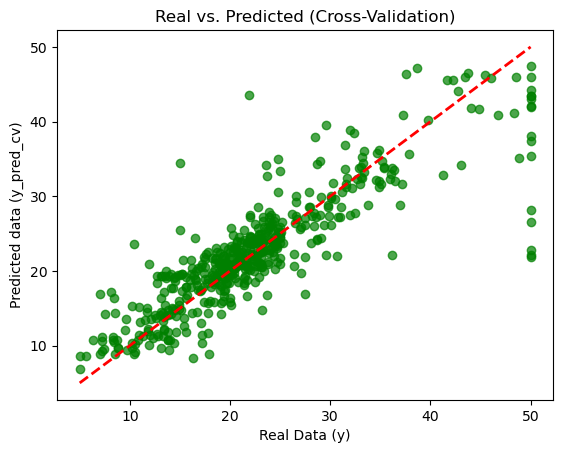

In [5]:
# Optimize with GridSearch:
folds = 5

# Grid 1: Optimize for Lasso
grid_1 = {
    'model': [Lasso()],
    'model__alpha': [0.01, 0.1, 0.5],
    'model__max_iter': [2000]
}

# Grid 2: Optimize for Ridge
grid_2 = {
    'model': [Ridge()],
    'model__alpha': [0.1, 1.0, 10.0]
}

# Grid 3: Optimize for Random Forest (nota los parámetros diferentes)
grid_3 = {
    'model': [RandomForestRegressor(random_state=42)],
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10]
}

# Grid search:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=[grid_1, grid_2, grid_3],
    cv=folds,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Starting MLFlow experiment:
mlflow.set_experiment("boston_housing_grid_search")

with mlflow.start_run(run_name="Fourth try: GridSearchCV"):
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_r2_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best R2 (mean of CV): {best_r2_score:4f}")

    # Get predictions on every fold:
    y_pred_cv = cross_val_predict(best_model, X, y, cv=folds)

    # Calculate MSE:
    mse_score = mean_squared_error(y, y_pred_cv)
    print(f"MSE (promedio): {mse_score:.4f}")

    # Graph Real vs. Predicted:
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred_cv, alpha=0.7, c='green')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel("Real Data (y)")
    ax.set_ylabel("Predicted data (y_pred_cv)")
    ax.set_title("Real vs. Predicted (Cross-Validation)")

    # Saving the graph:
    fig.savefig("../reports/figures/real_vs_predicted_GridSearch.png")

    # Params:
    mlflow.log_params(best_params)

    # Metrics:
    mlflow.log_metric('best_cv_r2', best_r2_score)
    mlflow.log_metric('cv_mse', mse_score)

    # Artifacts:
    mlflow.sklearn.log_model(best_model, 'best_lasso_model_from_gridsearch') # Model
    mlflow.log_artifact("../reports/figures/real_vs_predicted_GridSearch.png") # Graph